---
#### IBM Data Science  -  Applied Data Science Capstone
# <b> Optimum relocation </b>

### <b> by Xavier Martínez </b>
####  January 2020

###### This JupyterLab notebook has been developed as capstone project of the course IBM Applied Data Science  which is part of the overall course IBM Data Science Professional Certificate.
---

## Objective: 
##### Several people nowadays relocate for different reasons and in many occasions the person relocating may not be familiar with the city in which he will be moving into, or even that the city to be relocated into is not determined.
##### The circumstances for relocating may be very diverse, but an element that probably is common in any case is that every individual relocating will have an idea of what kind of place it should be.

##### The objective of this project is to develop a tool that would allow identifying the area or neighbourhood in a city or a group of cities that best matches the requirements of an individual that will be relocating. 
##### The requirements would be expressed as an area or neighbourhood that the person relocating would indicate. 
##### The criteria to be considered in comparing areas would include the presence of a wide range of venues such as social, cultural, entertainment, schools or natural environment; and other factors such as quality of life, cost of living, safety, health care, climate and pollution.

### Example implemented
##### The code developed presents a particular case. The area to take as requirements is Richmond (United Kingdom) and the cities where relocation is considered are Madrid (Spain), Frankfurt (Germany), Singapore (Singapore) and Queens NY (United States).
---

## Preparation of the notebook
#### Import libraries

In [1]:
# Preparing the environment for the notebook
# Installing if required and importing the libraries to be used

import sys
print(sys.version)

#!conda install -c conda-forge folium=0.5.0 --yes
#!conda install -c conda-forge geopy --yes
#!conda install -c conda-forge geocoder --yes
#!pip install  beautifulsoup4

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


import requests
import io

import folium
import json 
from pandas.io.json import json_normalize

import math

# import k-means from clustering stage
from sklearn.cluster import KMeans

# Matplotlib and associated plotting modules
%matplotlib inline
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

import pickle

print('All libraries imported successfully')

3.7.4 (default, Aug  9 2019, 18:34:13) [MSC v.1915 64 bit (AMD64)]
All libraries imported successfully


#### Collect APIs credentials

In [2]:
# Load the Credentials for the APIs that will be used

# FOURSQUARE
f = open('Credentials_Foursquare_API.pckl', 'rb')
cred = pickle.load(f)
f.close()
FS_CLIENT_ID = cred['CLIENT_ID']
FS_CLIENT_SECRET = cred['CLIENT_SECRET']

# GOOGLE MAPS 
f = open('Credentials_Google_API.pckl', 'rb')
cred = pickle.load(f)
f.close()
GL_KEY = cred['KEY']

# NUMBEO
f = open('Credentials_Numbeo_API.pckl', 'rb')
cred = pickle.load(f)
f.close()
NM_KEY = cred['KEY']

## Collect cities information

In [3]:
#Definition of a function to obtain the coordinates form a certan address using GOOGLE MAPS API
def get_coords(api_key, address, verbose=False):
    try:
        url = 'https://maps.googleapis.com/maps/api/geocode/json?key={}&address={}'.format(api_key, address)
        response = requests.get(url).json()
        if verbose:
            print('Google Maps API JSON result =>', response)
        results = response['results']
        coordinates = results[0]['geometry']['location'] # get geographical coordinates
        lat = coordinates['lat']
        lon = coordinates['lng']
        return [lat, lon]
    except:
        return [None, None]

In [4]:
# A map showing the reference Neighbourhood and the potendial cities where to relocate is created

# Information regarding the city and neighbourhood of reference
city_ref=['Richmond']
neighbourhood_ref=['Richmond']
country_ref=['United Kingdom']

# Information regarding the cities where relocation will be considered
city_list=['Singapore','Madrid','Frankfurt','Queens NY']
country_list=['Singapore','Spain','Germany','United States']

# Amalgamation of the lists to pass them to the loop below
city_list.insert(0,city_ref[0])
country_list.insert(0,country_ref[0])

columns=['City','Country','Latitude','Longitude']
cities_df=pd.DataFrame(columns=columns)

# Collection of the cities coordinates
for city,country in zip(city_list,country_list):
    address = city + country
    address_coords = get_coords(GL_KEY,address)
    city_latitude = address_coords[0]
    city_longitude = address_coords[1]
    cities_df = cities_df.append({'City': city,
                                  'Country': country,
                                  'Latitude': city_latitude,
                                  'Longitude': city_longitude}, ignore_index=True)

cities_df

,City,Country,Latitude,Longitude
0,Richmond,United Kingdom,51.461311,-0.303742
1,Singapore,Singapore,1.352083,103.819836
2,Madrid,Spain,40.416775,-3.703790
3,Frankfurt,Germany,50.110922,8.682127
4,Queens NY,United States,40.728224,-73.794852


In [5]:
# Preparation of the map, centered in the city of reference
map_city = folium.Map(location=[cities_df['Latitude'][0], cities_df['Longitude'][0]], zoom_start=3)

# add markers to map
city_count=0
for lat, lng, label in zip(cities_df['Latitude'], cities_df['Longitude'], cities_df['City']):
    label = folium.Popup(label, parse_html=True)
    if city_count==0:     
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='red',
            fill=True,
            fill_color='#cc8931',
            fill_opacity=0.7,
            parse_html=False).add_to(map_city) 
        city_count+=1
    else:
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map_city) 
        city_count+=1
map_city

## Collect neighbourhoods coordinates

In [6]:
# Collect coordinates for all the neighbourhoods 
# The names of the neighbourhoods have been saved in list into a pckl file

# Create a df to store the Neighourhoods information
# define the dataframe columns

#del Neighbourhoods  # case the dataframe needs to be reinitiated

column_names = ['City','Neighbourhood', 'Latitude', 'Longitude'] 
# instantiate the dataframe
Neighbourhoods = pd.DataFrame(columns=column_names)

city_count=0
for city,country in zip(city_list,country_list):
    if city_count==0:
        city_Neighbourhoods=neighbourhood_ref
        city_count+=1
    else:
        file_name='Neighbourhoods_'+city+'.pckl'
        print('reading ',file_name)
        f = open(file_name, 'rb')
        city_Neighbourhoods = pickle.load(f)
        f.close()
        city_count+=1
    print('gathering coords for {} neighbourhoods'.format(len(city_Neighbourhoods)))
    for i in range(0,len(city_Neighbourhoods)):
        try:
            hood=city_Neighbourhoods[i]
            address = hood + ', ' + city + ', ' + country
            address_coords=get_coords(GL_KEY,address)
            latitude = address_coords[0]
            longitude = address_coords[1]
#           print('The geographical coordinates for {}, num {} are {}, {}.'.format(address,i,latitude, longitude))
            Neighbourhoods = Neighbourhoods.append({'City': city,
                                                    'Neighbourhood': hood,
                                                    'Latitude': latitude,
                                                    'Longitude': longitude}, ignore_index=True)
        except:
            print('Coordinates for {},{} not found'.format(city,hood))

city_count=len(Neighbourhoods['City'].unique())
hood_count=len(Neighbourhoods)
print('A total of {} neighbourhoods from {} cities will be considered'.format(hood_count,city_count))

gathering coords for 1 neighbourhoods
reading  Neighbourhoods_Singapore.pckl
gathering coords for 75 neighbourhoods
reading  Neighbourhoods_Madrid.pckl
gathering coords for 21 neighbourhoods
reading  Neighbourhoods_Frankfurt.pckl
gathering coords for 17 neighbourhoods
reading  Neighbourhoods_Queens NY.pckl
gathering coords for 32 neighbourhoods
A total of 146 neighbourhoods from 5 cities will be considered


In [7]:
# Ploting a map for each of the cities considered showing the neighbourhoods that will be analysed
# Note that maps in folium cannot be produced inside a loop, hence every map will be potted from a 
# different cell (identical appart of the index i)
i=1
city_name = cities_df['City'][i]
city_latitude = cities_df['Latitude'][i]
city_longitude = cities_df['Longitude'][i]
print('The geographical coordinates for {} are {}, {}.'.format(city_name,city_latitude, city_longitude))

map_city = folium.Map(location=[city_latitude, city_longitude], zoom_start=12)

# add markers to map
for lat, lng, label in zip(Neighbourhoods['Latitude'], Neighbourhoods['Longitude'], Neighbourhoods['Neighbourhood']):
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
                [lat, lng],
                radius=5,
                popup=label,
                color='red',
                fill=True,
                fill_color='#cc8931',
                fill_opacity=0.7,
                parse_html=False).add_to(map_city)  

map_city

The geographical coordinates for Singapore are 1.352083, 103.819836.


In [8]:
# Ploting a map for each of the cities considered showing the neighbourhoods that will be analysed
# Note that maps in folium cannot be produced inside a loop, hence every map will be potted from a 
# different cell (identical appart of the index i)
i=2
city_name = cities_df['City'][i]
city_latitude = cities_df['Latitude'][i]
city_longitude = cities_df['Longitude'][i]
print('The geographical coordinates for {} are {}, {}.'.format(city_name,city_latitude, city_longitude))

map_city = folium.Map(location=[city_latitude, city_longitude], zoom_start=12)

# add markers to map
for lat, lng, label in zip(Neighbourhoods['Latitude'], Neighbourhoods['Longitude'], Neighbourhoods['Neighbourhood']):
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
                [lat, lng],
                radius=5,
                popup=label,
                color='red',
                fill=True,
                fill_color='#cc8931',
                fill_opacity=0.7,
                parse_html=False).add_to(map_city)  

map_city

The geographical coordinates for Madrid are 40.4167754, -3.7037902.


In [9]:
# Ploting a map for each of the cities considered showing the neighbourhoods that will be analysed
# Note that maps in folium cannot be produced inside a loop, hence every map will be potted from a 
# different cell (identical appart of the index i)
i=3
city_name = cities_df['City'][i]
city_latitude = cities_df['Latitude'][i]
city_longitude = cities_df['Longitude'][i]
print('The geographical coordinates for {} are {}, {}.'.format(city_name,city_latitude, city_longitude))

map_city = folium.Map(location=[city_latitude, city_longitude], zoom_start=12)

# add markers to map
for lat, lng, label in zip(Neighbourhoods['Latitude'], Neighbourhoods['Longitude'], Neighbourhoods['Neighbourhood']):
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
                [lat, lng],
                radius=5,
                popup=label,
                color='red',
                fill=True,
                fill_color='#cc8931',
                fill_opacity=0.7,
                parse_html=False).add_to(map_city)  

map_city

The geographical coordinates for Frankfurt are 50.1109221, 8.6821267.


In [10]:
# Ploting a map for each of the cities considered showing the neighbourhoods that will be analysed
# Note that maps in folium cannot be produced inside a loop, hence every map will be potted from a 
# different cell (identical appart of the index i)
i=4
city_name = cities_df['City'][i]
city_latitude = cities_df['Latitude'][i]
city_longitude = cities_df['Longitude'][i]
print('The geographical coordinates for {} are {}, {}.'.format(city_name,city_latitude, city_longitude))

map_city = folium.Map(location=[city_latitude, city_longitude], zoom_start=12)

# add markers to map
for lat, lng, label in zip(Neighbourhoods['Latitude'], Neighbourhoods['Longitude'], Neighbourhoods['Neighbourhood']):
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
                [lat, lng],
                radius=5,
                popup=label,
                color='red',
                fill=True,
                fill_color='#cc8931',
                fill_opacity=0.7,
                parse_html=False).add_to(map_city)  

map_city

The geographical coordinates for Queens NY are 40.7282239, -73.7948516.


## Collect venues information

In [17]:
# Define the parameter for loading information into Foursquare API
VERSION = '20180605' # Foursquare API version
LIMIT = 300 
radius = 1400 

In [18]:

def getNearbyVenues(cities,names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    cont=0
    for city,name, lat, lng in zip(cities,names, latitudes, longitudes):
        cont=cont+1
#        print(cont,"of",len(names),name,', ',city)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            FS_CLIENT_ID, 
            FS_CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            city,
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City',
                  'Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [19]:
city_venues = getNearbyVenues(cities=Neighbourhoods['City'],
                              names=Neighbourhoods['Neighbourhood'],
                              latitudes=Neighbourhoods['Latitude'],
                              longitudes=Neighbourhoods['Longitude'])

## Analyse and clean collected venues data

In [20]:
# size of the dataframe and a first glimpse:
print(city_venues.shape)
city_venues.head(10)

(5814, 8)


,City,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Richmond,Richmond,51.461311,-0.303742,Richmond Green,51.461250,-0.305918,Park
1,Richmond,Richmond,51.461311,-0.303742,Al Boccon Di’vino,51.459607,-0.304772,Italian Restaurant
2,Richmond,Richmond,51.461311,-0.303742,Kiss the Hippo Coffee,51.460919,-0.304230,Coffee Shop
3,Richmond,Richmond,51.461311,-0.303742,Ole & Steen,51.460587,-0.304967,Coffee Shop
4,Richmond,Richmond,51.461311,-0.303742,Richmond Theatre,51.462130,-0.304009,Theater
5,Richmond,Richmond,51.461311,-0.303742,Gelateria Danieli,51.460967,-0.305259,Ice Cream Shop
6,Richmond,Richmond,51.461311,-0.303742,Franco Manca,51.459547,-0.305041,Pizza Place
7,Richmond,Richmond,51.461311,-0.303742,Waterstones,51.459532,-0.305984,Bookstore
8,Richmond,Richmond,51.461311,-0.303742,No. 1 Duke Street,51.461412,-0.303828,Restaurant
9,Richmond,Richmond,51.461311,-0.303742,Rustica,51.462546,-0.302594,Italian Restaurant


In [21]:
# save the dataframe in a picle file for futre use withou haveing to retrieve all the information
file_name='Venues_full_list.pckl'
f = open(file_name, 'wb')
pickle.dump(city_venues, f)
f.close()

In [ ]:
# load the dataframe from a picle file
#file_name='Venues_full_list.pckl'
#f = open(file_name, 'rb')
#city_venues = pickle.load(f)
#f.close()

##### Analyse the number of venues collected per neighbourhood

In [22]:
# check by city what are the maximum and minimum number of venues in each neighbourhood
for city in city_list:
    count_max=city_venues[city_venues['City']==city].groupby('Neighbourhood')['Neighbourhood'].count().max()
    count_min=city_venues[city_venues['City']==city].groupby('Neighbourhood')['Neighbourhood'].count().min()
    print('The maximum and minimum counts in {} are: {},{}.'.format(city,count_max,count_min))

The maximum and minimum counts in Richmond are: 100,100.
The maximum and minimum counts in Singapore are: 100,1.
The maximum and minimum counts in Madrid are: 100,1.
The maximum and minimum counts in Frankfurt are: 100,2.
The maximum and minimum counts in Queens NY are: 200,4.


(array([20., 20., 11., 11., 12.,  6., 11.,  5.,  2.,  6.,  2.,  4.,  3.,
         3.,  3., 17.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         1.,  0.,  0.,  0.,  0.,  1.]),
 array([  1.     ,   7.21875,  13.4375 ,  19.65625,  25.875  ,  32.09375,
         38.3125 ,  44.53125,  50.75   ,  56.96875,  63.1875 ,  69.40625,
         75.625  ,  81.84375,  88.0625 ,  94.28125, 100.5    , 106.71875,
        112.9375 , 119.15625, 125.375  , 131.59375, 137.8125 , 144.03125,
        150.25   , 156.46875, 162.6875 , 168.90625, 175.125  , 181.34375,
        187.5625 , 193.78125, 200.     ]),
 <a list of 32 Patch objects>)

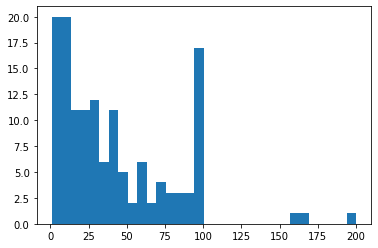

In [23]:
# A histogram of the number of venues per neighbourhood provides a good
# understanding of what the distribution of the information gathered.
# Will also inform on what the treshold for the number of venues should be
# to disrigard neighbourhoods with not enough data
plt.hist(city_venues.groupby('Neighbourhood')['Neighbourhood'].count(),32,cumulative=False)

In [24]:
# The cleanning of the data will be undertaken in a copy of the full list
city_venues_clean=city_venues

In [25]:
# Creation of a list of Neighbourhoods with not enough data to be considered
# Define the minimum number of venues per neighbourhood
treshold_venues=20
no_data_list=[]
for hood in city_venues_clean['Neighbourhood'].unique():
    if city_venues_clean.groupby('Neighbourhood')['Neighbourhood'].count()[hood] < treshold_venues:
        no_data_list.append(hood)
        
print('The number of neighbourhoods that will be disregarded is {} out of {}.'.format(len(no_data_list),len(city_venues_clean['Neighbourhood'].unique())))

The number of neighbourhoods that will be disregarded is 51 out of 139.


In [26]:
# This function removes registers based on their content

def remove_registers(venues_list,word_search,field_search):
#    word_search:   is the list of words to be found 
#    field_search:  is the list of fields were the words will be search
#    the field_search list should be a subset of:
#    ['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 'Venue',
#     'Venue Latitude', 'Venue Longitude', 'Venue Category']

    # The number of registers before the removal is found and shown
    num_orig=len(venues_list)
    print('Number of registers before removal: ',num_orig)
    #All the registers were any word of the list is in any field of the list will be removed
    print('Searching for: ',word_search)
    print('Searcing in: ',field_search)
    for word in word_search:
        for field in field_search:
            venues_list = venues_list[venues_list[field].str.contains(word) == False]

    # The number of regiters after the removal are found and shown
    print('Number of registers after removal: ',len(venues_list))
    print('Number of registers removed: ',num_orig-len(venues_list))

    return(venues_list)

In [27]:
# This cell removes neighbourhoods where the number of venues is below the determined treshold
city_venues_clean = remove_registers(city_venues_clean,no_data_list,['Neighbourhood'])

Number of registers before removal:  5814
Searching for:  ['Telok Blangah', 'Hong Leong Garden', 'River Valley', 'Bukit Timah', 'Tanglin', 'Watten Estate', 'Thomson', 'Serangoon', 'Macpherson', 'Eunos', 'Upper East Coast', 'Eastwood', 'Kew Drive', 'Loyang', 'Changi', 'Simei', 'Tampines', 'Punggol', 'Upper Bukit Timah', 'Clementi Park', 'Ulu Pandan', 'Tuas', 'Dairy Farm', 'Bukit Panjang', 'Lim Chu Kang', 'Tengah', 'Kranji', 'Woodgrove', 'Upper Thomson', 'Springleaf', 'Sembawang', 'Seletar', 'Fuencarral-El Pardo', 'Moncloa-Aravaca', 'Latina', 'Carabanchel', 'Usera', 'Puente de Vallecas', 'Moratalaz', 'Hortaleza', 'Villaverde', 'Villa de Vallecas', 'Vicálvaro', 'Barajas', 'Flughafen', 'Niederrad', 'Oberrad', 'Queensbridge,', 'Blissville,', 'Point,', 'East']
Searcing in:  ['Neighbourhood']
Number of registers after removal:  5304
Number of registers removed:  510


In [28]:
# In some occations Neighbourhood appears as Venue Category
# Those instances need to be removed from the data set
city_venues_clean = remove_registers(city_venues_clean,['Neighbourhood'],['Venue Category'])

Number of registers before removal:  5304
Searching for:  ['Neighbourhood']
Searcing in:  ['Venue Category']
Number of registers after removal:  5304
Number of registers removed:  0


##### Analyse the categories of the venues in the data collected

In [29]:
# Firstly find out how many different categories have been identified
print('There are {} unique categories.'.format(len(city_venues_clean['Venue Category'].unique())))
all_cat=list(city_venues['Venue Category'].unique())
#city_venues['Venue Category'].unique()

There are 344 unique categories.


In [30]:
# Load the Category reduction criteria 
# That will alloc to redefine categories to have a reduced number of categories,
# more representative of the neighbourhood
f = open('Cat_red_13.pckl', 'rb')
cat_lists_dic = pickle.load(f)
f.close()

In [31]:
# Reduction of the categories 
for cat_name, cat_cont in zip(list(cat_lists_dic.keys()),list(cat_lists_dic.values())):
    for subcat_name in cat_cont:
        city_venues_clean.replace(to_replace=subcat_name,value=cat_name,inplace=True)

print('There are {} unique categories.'.format(len(city_venues_clean['Venue Category'].unique())))
city_venues_clean['Venue Category'].unique()
    

There are 11 unique categories.


array(['Outdoors & Recreation', 'Restaurants', 'Cafe',
       'Arts & Entertainment', 'Food', 'Shop & Service', 'Nightlife Spot',
       'Travel & Transport', 'Professional & Other Places', 'Residence',
       'College & University'], dtype=object)

## Analyse cleaned data

In [32]:
# Initially analyse data by Neighbourhood and by taking the mean of
# the frequency of occurrence of each category

#del city_onehot # uncomment if the cell needs to be rerun

# one hot encoding
city_onehot = pd.get_dummies(city_venues_clean[['Venue Category']], prefix="", prefix_sep="")
# add City and Neighbourhood column as first and second columns
city_onehot.insert(0,'City', city_venues_clean['City'])
city_onehot.insert(1,'Neighbourhood', city_venues_clean['Neighbourhood'])
print(city_onehot.shape)

(5304, 13)


In [33]:
city_grouped = city_onehot.groupby('Neighbourhood').mean().reset_index()
print('The grouped df shape is: ',city_grouped.shape)
city_grouped.head()

The grouped df shape is:  (87, 12)


,Neighbourhood,Arts & Entertainment,Cafe,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Restaurants,Shop & Service,Travel & Transport
0,Altstadt,0.070000,0.150000,0.0,0.080000,0.100000,0.120000,0.010000,0.0,0.280000,0.170000,0.020000
1,Amber Road,0.043478,0.043478,0.0,0.086957,0.086957,0.086957,0.043478,0.0,0.434783,0.130435,0.043478
2,Ang Mo Kio,0.033898,0.152542,0.0,0.305085,0.000000,0.050847,0.000000,0.0,0.288136,0.152542,0.016949
3,Anson,0.010000,0.180000,0.0,0.180000,0.050000,0.020000,0.010000,0.0,0.430000,0.060000,0.060000
4,Ardmore,0.054054,0.027027,0.0,0.054054,0.189189,0.027027,0.000000,0.0,0.324324,0.081081,0.243243


##### Display the top venues for each Neighbourhood.

In [34]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]


In [36]:
# create columns according to number of top venues
num_top_venues = min(10,len(city_grouped.keys())-1)
columns = ['Neighbourhood']
indicators = ['st', 'nd', 'rd']

for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
Neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
Neighbourhoods_venues_sorted['Neighbourhood'] = city_grouped['Neighbourhood']

for ind in np.arange(city_grouped.shape[0]):
    Neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(city_grouped.iloc[ind, :], num_top_venues)

Neighbourhoods_venues_sorted

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Altstadt,Restaurants,Shop & Service,Cafe,Outdoors & Recreation,Nightlife Spot,Food,Arts & Entertainment,Travel & Transport,Professional & Other Places,Residence
1,Amber Road,Restaurants,Shop & Service,Outdoors & Recreation,Nightlife Spot,Food,Travel & Transport,Professional & Other Places,Cafe,Arts & Entertainment,Residence
2,Ang Mo Kio,Food,Restaurants,Shop & Service,Cafe,Outdoors & Recreation,Arts & Entertainment,Travel & Transport,Residence,Professional & Other Places,Nightlife Spot
3,Anson,Restaurants,Food,Cafe,Travel & Transport,Shop & Service,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Arts & Entertainment,Residence
4,Ardmore,Restaurants,Travel & Transport,Nightlife Spot,Shop & Service,Food,Arts & Entertainment,Outdoors & Recreation,Cafe,Residence,Professional & Other Places
5,Arganzuela,Restaurants,Outdoors & Recreation,Nightlife Spot,Food,Shop & Service,Travel & Transport,Cafe,Residence,Professional & Other Places,College & University
6,Astoria,Restaurants,Food,Shop & Service,Nightlife Spot,Cafe,Outdoors & Recreation,Arts & Entertainment,Travel & Transport,Residence,Professional & Other Places
7,"Astoria,",Restaurants,Food,Shop & Service,Nightlife Spot,Cafe,Outdoors & Recreation,Arts & Entertainment,Travel & Transport,Residence,Professional & Other Places
8,Bahnhofsviertel,Restaurants,Travel & Transport,Food,Shop & Service,Nightlife Spot,Cafe,Outdoors & Recreation,Arts & Entertainment,Professional & Other Places,Residence
9,Balestier,Restaurants,Food,Travel & Transport,Shop & Service,Outdoors & Recreation,Residence,Professional & Other Places,Nightlife Spot,College & University,Cafe


#### Cluster neighbourhoods

In [37]:
# set number of clusters
kclusters = 7

city_grouped_clustering = city_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(city_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 1, 6, 1, 5, 0, 2, 2, 5, 2, 1, 2, 2, 4, 3, 2, 2, 4, 1, 1, 3, 1,
       2, 0, 2, 2, 2, 5, 2, 3, 6, 1, 6, 2, 3, 3, 4, 3, 0, 6, 6, 2, 0, 0,
       0, 3, 3, 3, 4, 2, 5, 1, 3, 6, 0, 4, 1, 1, 6, 1, 4, 0, 0, 5, 6, 1,
       2, 0, 2, 0, 1, 2, 2, 4, 1, 6, 2, 2, 1, 4, 3, 2, 3, 3, 6, 6, 4])

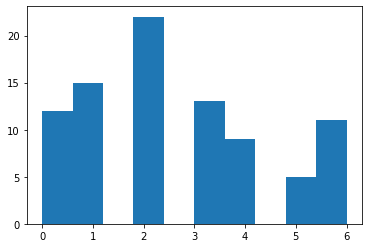

In [38]:
plt.hist(kmeans.labels_)
plt.show()

In [39]:
# Join the original data with the anlysis of the Most Common Venues.
# Also add the Cluster Labels accordingly.

if not 'Cluster Labels' in Neighbourhoods_venues_sorted.columns:
    Neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

city_merged = Neighbourhoods

# merge toronto_grouped with toronto_data to add latitude/longitude for each Neighbourhood
city_merged = city_merged.join(Neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood', how='inner')

#toronto_merged
city_merged.head(10)

,City,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Richmond,Richmond,51.461311,-0.303742,1,Restaurants,Nightlife Spot,Food,Shop & Service,Cafe,Outdoors & Recreation,Arts & Entertainment,Travel & Transport,Residence,Professional & Other Places
1,Singapore,Raffles Place,1.284484,103.851345,0,Restaurants,Outdoors & Recreation,Nightlife Spot,Food,Cafe,Travel & Transport,Professional & Other Places,Arts & Entertainment,Shop & Service,Residence
2,Singapore,Cecil,1.279653,103.848318,1,Restaurants,Cafe,Food,Nightlife Spot,Outdoors & Recreation,Travel & Transport,Shop & Service,Professional & Other Places,Arts & Entertainment,Residence
3,Singapore,Marina,1.287794,103.866555,0,Outdoors & Recreation,Arts & Entertainment,Restaurants,Food,Cafe,Shop & Service,Travel & Transport,Nightlife Spot,Residence,Professional & Other Places
4,Singapore,People's Park,1.284198,103.842549,1,Restaurants,Food,Shop & Service,Nightlife Spot,Travel & Transport,Cafe,Professional & Other Places,Outdoors & Recreation,Arts & Entertainment,Residence
5,Singapore,Anson,1.273615,103.844701,1,Restaurants,Food,Cafe,Travel & Transport,Shop & Service,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Arts & Entertainment,Residence
6,Singapore,Tanjong Pagar,1.278030,103.840447,1,Restaurants,Nightlife Spot,Food,Cafe,Outdoors & Recreation,Travel & Transport,Shop & Service,Arts & Entertainment,Residence,Professional & Other Places
7,Singapore,Bukit Merah,1.283560,103.819390,2,Restaurants,Food,Cafe,Shop & Service,Residence,Arts & Entertainment,Travel & Transport,Professional & Other Places,Outdoors & Recreation,Nightlife Spot
8,Singapore,Queenstown,1.294166,103.786127,2,Food,Restaurants,Cafe,Professional & Other Places,Nightlife Spot,Travel & Transport,Shop & Service,Outdoors & Recreation,Residence,College & University
9,Singapore,Tiong Bahru,1.286371,103.825298,3,Restaurants,Food,Cafe,Shop & Service,Outdoors & Recreation,Nightlife Spot,Travel & Transport,Residence,Professional & Other Places,College & University


##### Visualise the clusters

In [56]:
# Ploting clustering results. 
# set i=0 for a world map and zoom in each city.
# alternatively set i according to the city desired
i=4
city_name = cities_df['City'][i]
city_latitude = cities_df['Latitude'][i]
city_longitude = cities_df['Longitude'][i]
zoom = 12
if i==0: zoom=3
if i!=0: print('Clustering map for',city_name)
map_clusters = folium.Map(location=[city_latitude, city_longitude], zoom_start=zoom)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]


# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(city_merged['Latitude'], city_merged['Longitude'], city_merged['Neighbourhood'], city_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Clustering map for Queens NY


##### City reference cluster overview

In [41]:
city_ref_cluster = city_merged['Cluster Labels'][0]
print('The cluster for {} is {}.'.format(city_ref[0],city_ref_cluster))

The cluster for Richmond is 1.


In [51]:
city_ref_cluster = city_merged.loc[city_merged['Cluster Labels'] == city_ref_cluster,
                                   city_merged.columns[[0,1] + list(range(4, city_merged.shape[1]))]]
city_ref_cluster

,City,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Richmond,Richmond,1,Restaurants,Nightlife Spot,Food,Shop & Service,Cafe,Outdoors & Recreation,Arts & Entertainment,Travel & Transport,Residence,Professional & Other Places
2,Singapore,Cecil,1,Restaurants,Cafe,Food,Nightlife Spot,Outdoors & Recreation,Travel & Transport,Shop & Service,Professional & Other Places,Arts & Entertainment,Residence
4,Singapore,People's Park,1,Restaurants,Food,Shop & Service,Nightlife Spot,Travel & Transport,Cafe,Professional & Other Places,Outdoors & Recreation,Arts & Entertainment,Residence
5,Singapore,Anson,1,Restaurants,Food,Cafe,Travel & Transport,Shop & Service,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Arts & Entertainment,Residence
6,Singapore,Tanjong Pagar,1,Restaurants,Nightlife Spot,Food,Cafe,Outdoors & Recreation,Travel & Transport,Shop & Service,Arts & Entertainment,Residence,Professional & Other Places
16,Singapore,Beach Road (part),1,Restaurants,Food,Shop & Service,Cafe,Nightlife Spot,Travel & Transport,Arts & Entertainment,Outdoors & Recreation,Residence,Professional & Other Places
22,Singapore,Lavender,1,Restaurants,Food,Cafe,Travel & Transport,Shop & Service,Outdoors & Recreation,Nightlife Spot,Arts & Entertainment,Residence,Professional & Other Places
31,Singapore,Novena,1,Restaurants,Food,Cafe,Shop & Service,Travel & Transport,Outdoors & Recreation,Nightlife Spot,Residence,Professional & Other Places,College & University
42,Singapore,Amber Road,1,Restaurants,Shop & Service,Outdoors & Recreation,Nightlife Spot,Food,Travel & Transport,Professional & Other Places,Cafe,Arts & Entertainment,Residence
76,Madrid,Centro,1,Restaurants,Nightlife Spot,Food,Travel & Transport,Shop & Service,Outdoors & Recreation,Cafe,Arts & Entertainment,Professional & Other Places,Residence


## Consideration of the Numbeo indices
##### Collect indices

In [43]:
# From the Numbeo API will retrieve the indices for each city
# The indices that will consider are:
#   'quality_of_life_index'
#   'purchasing_power_incl_rent_index'
#   'safety_index'
#   'health_care_index'
#   'climate_index'
#   'pollution_index'

# I have already checked that for the Richmond, unfurtunatelly there are not registers.
# Given the proximity to London, I will take those indices as reference.
# Also the name used by Numbeo for New York is New York, NY; that will be considered in the code below.

# The idices will be stored in a dataframe

indices=['quality_of_life_index','purchasing_power_incl_rent_index','safety_index','health_care_index','climate_index','pollution_index']
indices_formated=['City','Quality of life','Purchasing power','Safety','Healthcare','Climate','Pollution']
nb_indices=pd.DataFrame(columns=indices_formated)

for city,country in zip(city_list,country_list):
    if city=='Richmond':
        q_city='London'
    elif city=='Queens NY':
        q_city='New York, NY'
    else:q_city=city
    q_country=country
    
    print('Retrieving indices for {} in {}'.format(q_city,q_country))
    url = 'https://www.numbeo.com/api/indices?&api_key={}&query={},{}'.format(NM_KEY,q_city,q_country)
    indices = requests.get(url).json()
   
    nb_indices = nb_indices.append({'City' : city,
                           'Quality of life' : indices['quality_of_life_index'],
                           'Purchasing power' : indices['purchasing_power_incl_rent_index'],
                           'Safety' : indices['safety_index'],
                           'Healthcare' : indices['health_care_index'],
                           'Climate' : indices['climate_index'],
                           'Pollution' : indices['pollution_index']}, ignore_index=True)
    

nb_indices

Retrieving indices for London in United Kingdom
Retrieving indices for Singapore in Singapore
Retrieving indices for Madrid in Spain
Retrieving indices for Frankfurt in Germany
Retrieving indices for New York, NY in United States


,City,Quality of life,Purchasing power,Safety,Healthcare,Climate,Pollution
0,Richmond,119.244422,77.878674,47.712168,68.406884,88.254338,60.638066
1,Singapore,144.358738,88.859402,69.464020,70.836230,57.453281,33.483621
2,Madrid,152.918820,74.211592,69.710169,79.313535,85.473048,53.293026
3,Frankfurt,174.257668,104.612589,59.782357,73.707203,84.716619,38.581419
4,Queens NY,141.932448,100.000000,55.561231,65.013747,79.661486,54.204299


##### Define and calculate distance

In [44]:
# Definition of a distance function that will measure how similar is one city to the city of reference,
# based on the indices. Note that a negative distance would mean an beneficial increase of the distances.

# Establish the weight of each index
ind_w=[3,2,2,3,2,1]

dist=np.zeros(5)

for i in range(1,len(city_list)):
    dist[i]=((nb_indices['Quality of life'][0]-nb_indices['Quality of life'][i])*ind_w[0]+
         (nb_indices['Purchasing power'][0]-nb_indices['Purchasing power'][i])*ind_w[1]+
         (nb_indices['Safety'][0]-nb_indices['Safety'][i])*ind_w[2]+
         (nb_indices['Healthcare'][0]-nb_indices['Healthcare'][i])*ind_w[3]+
         (nb_indices['Climate'][0]-nb_indices['Climate'][i])*ind_w[4]+
         (nb_indices['Pollution'][0]-nb_indices['Pollution'][i])*(-1)*ind_w[5]
          )/sum(ind_w)

# Add the column Distance at the nb_indices df
nb_indices['Distance'] = dist

In [45]:
# Add the column Distance at the nb_indices df
nb_indices['Distance'] = dist
nb_indices

,City,Quality of life,Purchasing power,Safety,Healthcare,Climate,Pollution,Distance
0,Richmond,119.244422,77.878674,47.712168,68.406884,88.254338,60.638066,0.000000
1,Singapore,144.358738,88.859402,69.464020,70.836230,57.453281,33.483621,-8.742190
2,Madrid,152.918820,74.211592,69.710169,79.313535,85.473048,53.293026,-13.245188
3,Frankfurt,174.257668,104.612589,59.782357,73.707203,84.716619,38.581419,-21.040778
4,Queens NY,141.932448,100.000000,55.561231,65.013747,79.661486,54.204299,-8.236424


## Final recommendation

In [52]:
# The recomentation will be based on the two selection criteria
# 1. Clustering
# 2. Distance

city_min_dist='Frankfurt'
city_ref_cluster.loc[(city_merged['City'] == city_min_dist),
                city_merged.columns[[0,1] + list(range(4, city_merged.shape[1]))]]

,City,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
99,Frankfurt,Gallus,1,Restaurants,Food,Travel & Transport,Nightlife Spot,Arts & Entertainment,Shop & Service,Professional & Other Places,College & University,Cafe,Residence
105,Frankfurt,Nordend-Ost,1,Restaurants,Nightlife Spot,Food,Cafe,Shop & Service,Travel & Transport,Outdoors & Recreation,Residence,Professional & Other Places,College & University
106,Frankfurt,Nordend-West,1,Restaurants,Cafe,Shop & Service,Food,Travel & Transport,Outdoors & Recreation,Nightlife Spot,Arts & Entertainment,Residence,Professional & Other Places
